## Install Packages

In [1]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install keras
!pip install tensorflow
!pip install SciPy
!pip install sklearn
!pip install scikit-learn
!pip install opencv-python
!pip install tensorflow

## Load Modules

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import keras
from keras.preprocessing.image import ImageDataGenerator
#from keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.applications.vgg19 import VGG19,preprocess_input , decode_predictions
from keras.applications.vgg16 import VGG16,preprocess_input , decode_predictions
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import cv2
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
import warnings
from keras.models import load_model
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [3]:
os.listdir("pneumonia/chest_xray/train")

['NORMAL', 'PNEUMONIA']

In [4]:
train_datagen=ImageDataGenerator(zoom_range= 0.5,shear_range=0.3,horizontal_flip= True,preprocessing_function = preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function= preprocess_input)

In [5]:
train = train_datagen.flow_from_directory(directory= "pneumonia/chest_xray/train",target_size=(256,256),batch_size=32)
val = val_datagen.flow_from_directory(directory= "pneumonia/chest_xray/train",target_size=(256,256),batch_size=32)

Found 5216 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.


In [6]:
t_img , label =train.next()

In [7]:
def plotImage(img_arr,label):
    for im , l in zip(img_arr , label):
        plt.figure(figsize=(5,5))
        plt.imshow(im/255)
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


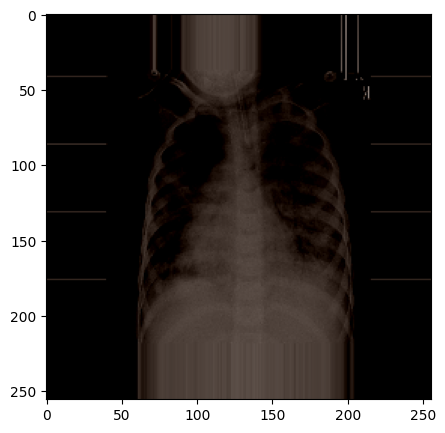

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


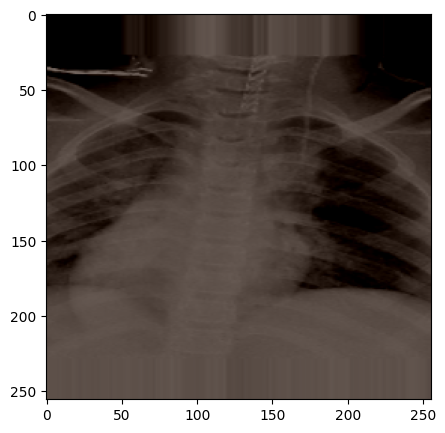

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


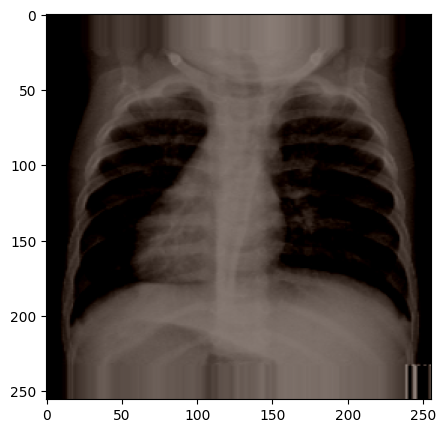

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


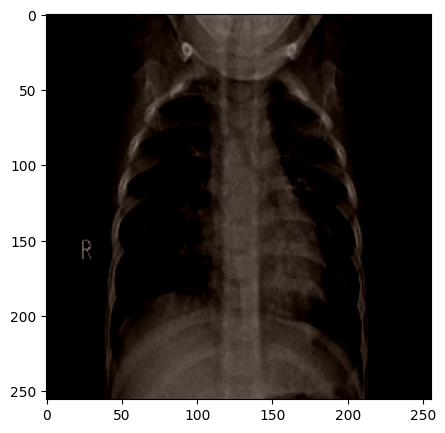

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


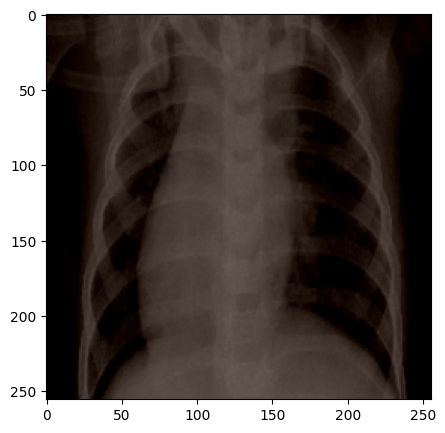

In [31]:
plotImage(t_img[:5],label[0:5])

### i) Using VGG-19 Feature Extractor + SVM

In [9]:
from keras.applications.vgg19 import VGG19,preprocess_input , decode_predictions

In [10]:
#The base_model variable is assigned a pre-trained VGG19 convolutional neural network model from Keras, which is configured to accept input images with a size of 256 x 256 pixels and with 3 color channels, and with the fully connected output layer removed (include_top=False).
base_model=VGG19(input_shape=(256,256,3), include_top= False)

In [11]:
#This loop sets the trainable attribute of each layer in the base_model to False, effectively freezing the weights of the pre-trained layers so that they are not updated during the training process of a new model built on top of base_model.
for layer in base_model.layers:
    layer.trainable = False

In [12]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [13]:
from keras.layers import Dense, Activation, Flatten
from tensorflow.keras.models import Model

In [14]:
#This code builds a new neural network model (model) on top of the pre-trained base_model by first flattening the output of base_model, then adding a new fully connected output layer with 2 units and a softmax activation function, and finally constructing a new Model object with the same input as base_model and the new output X.
X= Flatten()(base_model.output)
X= Dense(units= 2,activation= 'softmax')(X)
model= Model(base_model.input,X)

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [16]:
#This code imports the ModelCheckpoint and EarlyStopping classes from the keras.callbacks module, creates instances of these classes (mc and es) with specific monitoring and saving settings, and stores them in a list cb. These callbacks can be passed to the fit method of a Keras model to monitor the training process and save the best performing model based on certain criteria.
from keras.callbacks import ModelCheckpoint , EarlyStopping
#early stopping
es = EarlyStopping(monitor = 'val_accuracy',min_delta=0.01,patience=3,verbose=1)
#model check point
mc = ModelCheckpoint(filepath="best_mmodel.h5",monitor='val_accuracy',min_delta= 0.01,patience=3,verbose=1,save_best_only=True)
cb=[es,mc]

In [17]:
#This code compiles the Keras model by specifying the adam optimizer, the categorical cross-entropy loss function, and the accuracy metric to be used during the training process.
model.compile(optimizer= 'adam',loss= keras.losses.categorical_crossentropy, metrics = ['accuracy'])

In [18]:
#This code trains the Keras model using the fit method by specifying the train and val generators as input data sources, the number of training steps per epoch, the number of training epochs, the verbosity level, the list of callbacks (cb) to use, and the validation data and validation steps to use during training. The history of the training process is stored in the his variable.
his = model.fit(train ,steps_per_epoch= 16,epochs = 5,verbose= 1,callbacks= cb,validation_data=val ,validation_steps = 16)

Epoch 1/5
16/16 [==============================] - ETA: 0s - loss: 4.4654 - accuracy: 0.8125 
Epoch 1: val_accuracy improved from -inf to 0.92773, saving model to best_mmodel.h5
16/16 [==============================] - 499s 32s/step - loss: 4.4654 - accuracy: 0.8125 - val_loss: 1.6824 - val_accuracy: 0.9277
Epoch 2/5
16/16 [==============================] - ETA: 0s - loss: 2.4615 - accuracy: 0.8867 
Epoch 2: val_accuracy did not improve from 0.92773
16/16 [==============================] - 665s 43s/step - loss: 2.4615 - accuracy: 0.8867 - val_loss: 4.2678 - val_accuracy: 0.8750
Epoch 3/5
16/16 [==============================] - ETA: 0s - loss: 1.8523 - accuracy: 0.9219 
Epoch 3: val_accuracy improved from 0.92773 to 0.94922, saving model to best_mmodel.h5
16/16 [==============================] - 676s 43s/step - loss: 1.8523 - accuracy: 0.9219 - val_loss: 1.7099 - val_accuracy: 0.9492
Epoch 4/5
16/16 [==============================] - ETA: 0s - loss: 1.9645 - accuracy: 0.9180 
Epoch 4: 

0.9645593869731801


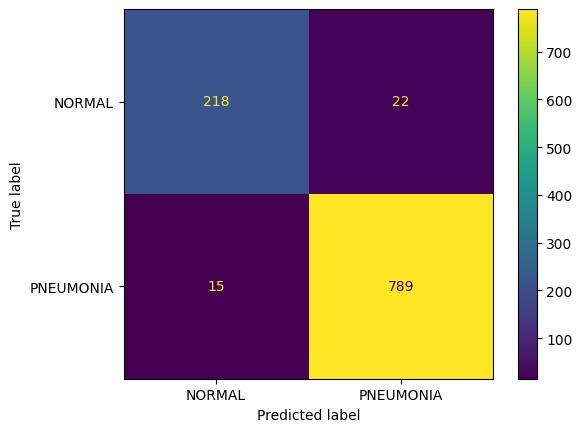

In [19]:
#This code performs binary classification of chest X-ray images into two classes - normal and pneumonia - using a support vector machine (SVM) with a radial basis function kernel. The confusion matrix and accuracy score are displayed using the confusion_matrix and ConfusionMatrixDisplay functions from scikit-learn.
classes={'NORMAL':0, 'PNEUMONIA':1}
X=[]
Y=[]
for cls in classes:
    pth="pneumonia/chest_xray/train/"+cls
    for j in os.listdir(pth):
        img = cv2.imread(pth+'/'+j, 0)
        img = cv2.resize(img, (200,200))
        X.append(img)
        Y.append(classes[cls])

X=np.array(X)
Y=np.array(Y)

X_updated= X.reshape(len(X), -1)

xtrain, xtest, ytrain, ytest = train_test_split(X_updated, Y, test_size=.20)

xtrain= xtrain/255
xtest= xtest/255

clf = SVC(random_state=0, tol=1e-5)
clf.fit(xtrain, ytrain)
predicted = clf.predict(xtest)
acc=accuracy_score(ytest, clf.predict(xtest))
print(acc)
cm=confusion_matrix(ytest, predicted, labels= clf.classes_)
cmdisp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NORMAL", "PNEUMONIA"])
cmdisp.plot()

In [20]:
#This line saves the trained Keras model to a file named "best_mmodel.h5" in the current directory.
model.save("best_mmodel.h5")

In [21]:
#This code loads a pre-trained Keras model from a saved file, applies it to a test image of a chest x-ray, preprocesses the image, predicts the class (normal or pneumonia) of the image using the loaded model, and prints the predicted class index (0 for normal, 1 for pneumonia) in the output.
model = load_model('best_mmodel.h5')
img = load_img('pneumonia/chest_xray/train/PNEUMONIA/person1_bacteria_1.jpeg', target_size=(256, 256))
i = img_to_array(img)
im = preprocess_input(i)
img = np.expand_dims(im,axis=0)
pred = np.argmax(model.predict(img))
print(pred)

1/1 [==============================] - 1s 786ms/step
1


In [22]:
#This code is printing the class name corresponding to the predicted class index obtained in the previous step.
for k in train.class_indices.keys():
    if train.class_indices[k]==pred:
        print(k)

PNEUMONIA


In [23]:
h = his.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

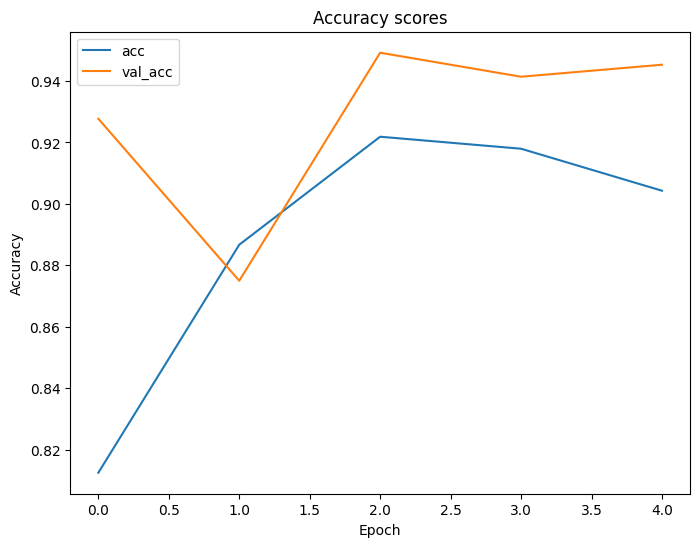

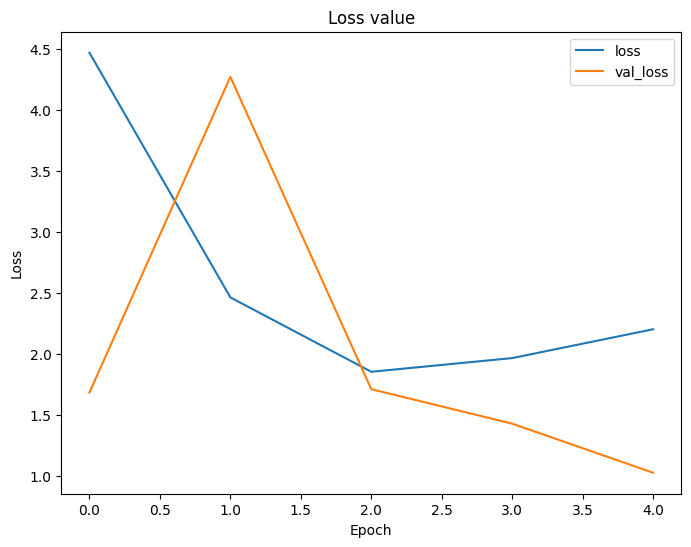

In [24]:
#Plotting the accuracy and loss curves
plt.figure(figsize=(8,6))
plt.title('Accuracy scores')
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['acc', 'val_acc'])
plt.show()
plt.figure(figsize=(8,6))
plt.title('Loss value')
plt.plot(h['loss'])
plt.plot(h['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [25]:
#Finding the accuracy, precision, recall, F1-Score
tn, fp, fn, tp = cm.ravel()
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {0:0.2f}%'.format(acc*100))
print('Precision: {0:0.2f}%'.format(precision))
print('Recall: {0:0.2f}%'.format(recall))
print('F1-score: {0:0.2f}'.format(2*precision*recall/(precision+recall)))

Accuracy: 0.96%
Precision: 97.29%
Recall: 98.13%
F1-score: 97.71


In [26]:
VGG16_ACC=acc*100
print(VGG16_ACC)

96.455938697318
